# LGCP + GP for Tract or Block Group Data


In [59]:
# Imports
import torch
from tqdm import  tqdm
import pyro
import pyro.distributions as dist
import gpytorch
import pandas as pd
import geopandas as gpd
from torch.utils.data import DataLoader
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ZeroMean
from gpytorch.models import ApproximateGP
from gpytorch.distributions import MultivariateNormal
from gpytorch.priors import GammaPrior
import matplotlib.pyplot as plt
from shapely.geometry import Point

import numpy as np
from scipy.stats import pearsonr

import rasterio
from rasterio.enums import Resampling
from rasterstats import zonal_stats
from scipy.optimize import curve_fit
import tempfile
import os

In [60]:
seed = 42  # Choose any fixed integer
np.random.seed(seed)
torch.manual_seed(seed)
pyro.set_rng_seed(seed)
torch.set_default_dtype(torch.float32)

In [61]:
wu_date = 'jul23_2021'
month_year = 'jul2021'
census_group_type = "block_group"
city_name = 'durham'
county_prefixes = ["37063"] # charlotte: ["37119"], durham: ["37063"], raleigh: ["37183"], asheville: ["37021"], CH: ["37135", "37063", "37037"]
time_slot = 'eve' # morn, af, eve
t_s_col = 't_s_night' if time_slot == 'eve' else 't_s_day'
m = 800 # num inducing points for LGCP

Then let's load the train and test data (involving the covariates):

In [62]:
# Assuming CSV or shapefile with 'lat', 'lon', 'temperature', and 'population' columns
if census_group_type == 'tract':
    df_geo = pd.read_csv(f"data/{wu_date}/nc_tracts_temp_pop_{time_slot}.csv")
    df_elev = pd.read_csv(f"data/{wu_date}/nc_tracts_elev_{t_s_col}_{time_slot}.csv")
elif census_group_type == 'block_group':
    df_geo = pd.read_csv(f"data/{wu_date}/nc_bg_temp_pop_{time_slot}.csv")
    df_elev = pd.read_csv(f"data/{wu_date}/nc_bg_elev_{t_s_col}_{time_slot}.csv")
else:
    raise ValueError("Invalid census group type. Choose 'tract' or 'block_group'.")
for df in (df_geo, df_elev):
    df["GEOID"] = df["GEOID"].astype(str)

# Remove waterID areal units:
shp_file = f"data/{wu_date}/nc_bg_temp_pop_{time_slot}.shp" if census_group_type == 'block_group' else f"data/{wu_date}/nc_tracts_temp_pop_{time_slot}.shp"
areal_units = gpd.read_file(shp_file)
areal_units["GEOID"] = areal_units["GEOID"].astype(str)
water_ids = set(areal_units.loc[(areal_units["ALAND"]==0) & (areal_units["AWATER"]>0), "GEOID"])
areal_units = areal_units.loc[~areal_units["GEOID"].isin(water_ids)]

df_geo = df_geo[~df_geo["GEOID"].isin(water_ids)].copy()
df_elev = df_elev[~df_elev["GEOID"].isin(water_ids)].copy()

# Merge tracts with elevation + add centroids
df_full = pd.merge(df_geo, df_elev[["GEOID", "elevation"]], on="GEOID", how="left")
geo_proj = areal_units.copy()
geo_proj = geo_proj.to_crs("EPSG:3857")
geo_proj["centroid"] = geo_proj.geometry.centroid
centroids_latlon = geo_proj.set_geometry("centroid").to_crs("EPSG:4326")
geo_proj["lon"] = centroids_latlon.geometry.x
geo_proj["lat"] = centroids_latlon.geometry.y
df_full = df_full.merge(geo_proj[["GEOID", "lat", "lon"]].copy(), on="GEOID", how="left")

# Merge MODIS surface temperature data with the tracts (by GEOID):
modis_df = df_elev.copy()
modis_df = modis_df[["GEOID", t_s_col]]
modis_df = modis_df[~modis_df["GEOID"].isin(water_ids)].copy()
df_full = df_full.merge(modis_df[["GEOID", t_s_col]], on="GEOID", how="left")

# Impute features (elevation, t_s_col)
from sklearn.impute import KNNImputer
impute_cols = ["lat", "lon", "elevation", t_s_col]
df_for_impute = df_full[impute_cols].copy()
imputer = KNNImputer(n_neighbors=5, weights='distance')
imputed = imputer.fit_transform(df_for_impute)
df_full["elevation"] = imputed[:, 2] # Update elevation col
df_full[t_s_col] = imputed[:, 3] # Update t_s col

# Only extract the non-nan values
mask = ~np.isnan(df_full[f"{time_slot}_temp"].values)
df_obs = df_full[mask].copy()

# Extract X (relevant covariates) and y (target variable)
X_cols = ["lat", "lon"]
X = df_obs[X_cols].values # X is observed coords only
y = df_obs[f"{time_slot}_temp"].values

In [63]:
# Lastly, we'll compute the coords for ALL centroids (for test_X)
shp = (f"data/{wu_date}/nc_tracts_temp_pop_{time_slot}.shp" if census_group_type == 'tract' else f"data/{wu_date}/nc_bg_temp_pop_{time_slot}.shp")
areal_units_all = gpd.read_file(shp).copy()
units_all_proj = areal_units_all.to_crs("EPSG:3857")
units_all_proj["centroid"] = units_all_proj.geometry.centroid
centroids_latlon = units_all_proj.set_geometry("centroid").to_crs("EPSG:4326")
areal_units_all["centroid_lon"] = centroids_latlon.geometry.x
areal_units_all["centroid_lat"] = centroids_latlon.geometry.y

# Separate out training and testing data
dtype = torch.get_default_dtype()
train_X = torch.tensor(X, dtype=dtype)
train_y = torch.tensor(y, dtype=dtype)
test_X  = torch.tensor(areal_units_all[["centroid_lat","centroid_lon"]].to_numpy(), dtype=dtype)

In [64]:
def select_inducing_with_min_sep(points_np, m=1000, eps_deg=1e-3, seed=42, max_passes=3):
    """
    Greedy selection: random order, keep a point only if it's at least eps_deg
    away (in lat/lon degrees) from all previously kept points.
    If we can't reach m, we progressively relax eps by half up to max_passes.
    """
    rng = np.random.default_rng(seed)
    points_np = points_np[np.isfinite(points_np).all(axis=1)]         # drop NaN/Inf
    points_np = np.unique(points_np, axis=0)                          # drop exact dups

    for _ in range(max_passes):
        keep = []
        perm = rng.permutation(len(points_np))
        eps2 = (eps_deg ** 2)

        for idx in perm:
            p = points_np[idx]
            if not keep:
                keep.append(p)
            else:
                # squared distance to all kept (lat/lon euclidean in degrees)
                d2 = np.sum((np.asarray(keep) - p) ** 2, axis=1)
                if np.min(d2) > eps2:
                    keep.append(p)
            if len(keep) >= m:
                break

        if len(keep) >= m:
            keep = np.asarray(keep)[:m]
            break
        else:
            # relax the threshold and try again
            eps_deg *= 0.5

    keep = np.asarray(keep)
    # If still short, randomly top up without replacement (duplicates already removed)
    if keep.shape[0] < m:
        remaining = points_np[~np.in1d(points_np.view([('', points_np.dtype)]*2),
                                       keep.view([('', keep.dtype)]*2))]
        need = min(m - keep.shape[0], remaining.shape[0])
        if need > 0:
            keep = np.vstack([keep, remaining[rng.choice(len(remaining), size=need, replace=False)]])
    # tiny jitter to avoid exact equalities
    keep = keep + rng.standard_normal(keep.shape) * 1e-9
    return keep[:m]


In [65]:
all_centroids = areal_units_all[["centroid_lat","centroid_lon"]].to_numpy()
mu = areal_units_all[["centroid_lat","centroid_lon"]].to_numpy().mean(axis=0)
std = areal_units_all[["centroid_lat","centroid_lon"]].to_numpy().std(axis=0)
all_centroids = (all_centroids - mu)/std
Z = select_inducing_with_min_sep(all_centroids, m=m, eps_deg=1e-3, seed=seed)
inducing_points = torch.tensor(Z, dtype=torch.get_default_dtype())

In [66]:
class LGCP_Model(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, name_prefix="cox_gp_model"):
        self.name_prefix = name_prefix

        # Define the variational distribution and strategy of the GP
        variational_distribution = gpytorch.variational.MeanFieldVariationalDistribution(num_inducing_points=inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, 
            inducing_points, 
            variational_distribution, 
            learn_inducing_locations=True
        )

        # Define model
        super().__init__(variational_strategy=variational_strategy)

        # Define mean and kernel
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5, active_dims = [0, 1], ard_num_dims=2))

    def forward(self, coords):
        mean = self.mean_module(coords)
        covar = self.covar_module(coords)
        return gpytorch.distributions.MultivariateNormal(mean, covar)

    def guide(self, observed_points, counts, population):
        # Variational parameters for alpha1 (slope of latent GP in log-intensity fn)
        alpha1_loc = pyro.param(self.name_prefix + ".alpha1_loc", torch.tensor(-0.5))
        alpha1_scale = pyro.param(
            self.name_prefix + ".alpha1_scale",
            torch.tensor(1.0),
            constraint=dist.constraints.positive,
        )
        pyro.sample(self.name_prefix + ".alpha1", dist.Normal(alpha1_loc, alpha1_scale))

        alpha0_loc = pyro.param(self.name_prefix + ".alpha0_loc", torch.tensor(-1.0)) # alpha0 = intercept of latent GP in log-intensity fn
        alpha0_scale = pyro.param(
            self.name_prefix + ".alpha0_scale",
            torch.tensor(1.0),
            constraint=dist.constraints.positive,
        )
        pyro.sample(self.name_prefix + ".alpha0", dist.Normal(alpha0_loc, alpha0_scale))

        #####################################################
        # Returns a MVN that approximates q(f(x)), the posterior over function values at observed points
        function_distribution = self.pyro_guide(observed_points)

        # Sample from q(x) at observed_points --> samples are used to compute gradients during training (i.e. for ELBO)
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            pyro.sample(
                self.name_prefix + ".function_samples",
                function_distribution
            )

    # Defines generative model for the LGCP: p(y, f(x))
    def model(self, observed_points, counts, population):
        pyro.module(self.name_prefix + ".gp", self)
        function_distribution = self.pyro_model(
            observed_points
        )
        # Draw samples from GP prior p(f) at observed_points
        with pyro.plate(self.name_prefix + ".times_plate", dim=-1):
            function_samples = pyro.sample(
                self.name_prefix + ".function_samples",
                function_distribution
            )

        ####
        # Convert function samples into intensity samples, using the function above
        ####
        alpha0 = pyro.sample(self.name_prefix + ".alpha0", dist.Normal(-1.0, 1.0)) # Set prior here on alpha0, alpha1
        alpha1 = pyro.sample(self.name_prefix + ".alpha1", dist.Normal(-0.5, 0.5))
        # Latent log intensity (before applying exp)
        log_lambda = alpha0 + alpha1 * function_samples
        lambda_ = log_lambda.exp()
        # Multiply by population to get Poisson rate (expected count per region)
        rate = lambda_ * population
        # Observe the actual counts via Poisson
        with pyro.plate(self.name_prefix + ".counts", dim=-1):
            pyro.sample(
                self.name_prefix + ".observed",
                dist.Poisson(rate),
                obs=counts
            )
        # Store for downstream use or plotting
        self.arrival_intensity_samples = rate

In [67]:
# Re-run this if you refit the model
pyro.clear_param_store()
lgcp_model = LGCP_Model(inducing_points)


In [68]:
train_X = torch.tensor(X, dtype=dtype)
mu = train_X.mean(axis=0)
std = train_X.std(axis=0)
train_X = (train_X - mu) / std

In [69]:
test_X = (test_X - mu) / std

In [70]:
num_iter = 300
num_particles = 32

population = torch.from_numpy(areal_units_all['population'].values / 1000 + 1e-2).float()
counts = torch.from_numpy(areal_units_all["count"].values).float()

def train(lr=0.01):
    losses = []
    optimizer = pyro.optim.Adam({"lr": lr})
    loss = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True)
    infer = pyro.infer.SVI(lgcp_model.model, lgcp_model.guide, optimizer, loss=loss)

    lgcp_model.train()
    loader = tqdm(range(num_iter))
    for i in loader:
        loss = infer.step(test_X, counts, population)
        losses.append(loss)
        loader.set_postfix(loss=loss)
    return losses

lgcp_model.train()
losses = train()
# BLOCK GROUPS: runs in ~3 minutes


100%|██████████| 300/300 [01:41<00:00,  2.94it/s, loss=5.74e+3]


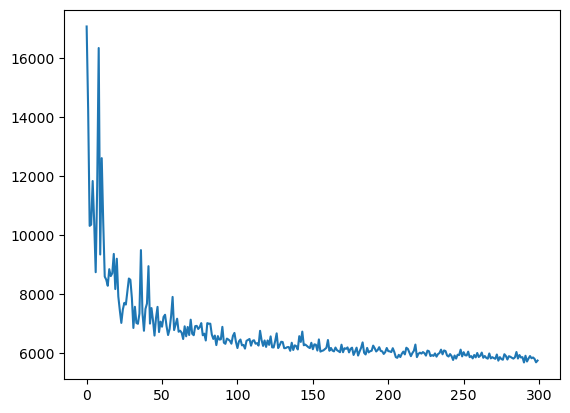

In [71]:
plt.plot(losses)

In [72]:
# test_X  = torch.tensor(areal_units_all[["centroid_lat","centroid_lon"]].to_numpy(), dtype=dtype)
# test_X = (test_X - mu) / std

In [73]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]
    return percentile_samples

lgcp_model.eval()
with torch.no_grad():
    function_dist = lgcp_model(test_X)
    latent_samples = function_dist(torch.Size([1000]))  # samples from variational posterior
    alpha0 = pyro.param("cox_gp_model.alpha0_loc")
    alpha1 = pyro.param("cox_gp_model.alpha1_loc")
    lambda_samples = (alpha0 + alpha1 * latent_samples).exp()
    lower, mean, upper = percentiles_from_samples(latent_samples)


In [74]:
mean = latent_samples.mean(axis=0)

(np.float64(-84.76790615526676),
 np.float64(-74.95403274529028),
 np.float64(33.61111504763127),
 np.float64(36.7298999997432))

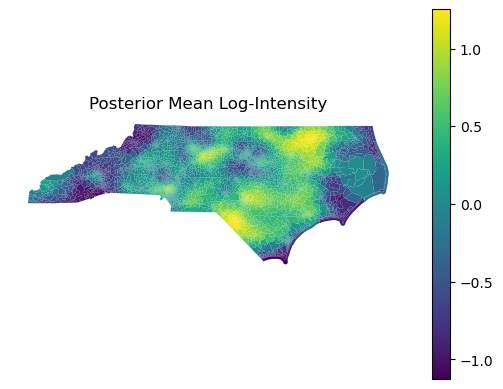

In [75]:
areal_units_all["log_lambda_mean"] = mean.numpy()

areal_units_all.plot(column="log_lambda_mean", cmap="viridis", legend=True)
plt.title("Posterior Mean Log-Intensity")
plt.axis("off")



In [76]:
population.shape

torch.Size([7111])

In [77]:
# keep = areal_units_all['GEOID'].astype(str).str.startswith(county_prefix)
geoid_str = areal_units_all["GEOID"].astype(str)
keep = geoid_str.str.startswith(tuple(county_prefixes))

<Axes: >

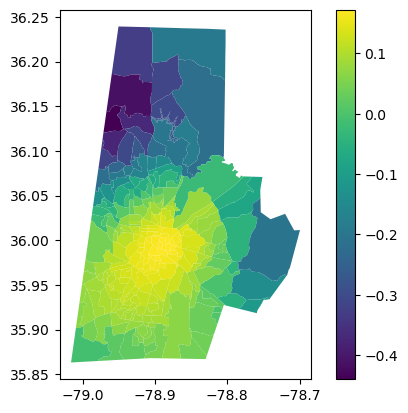

In [78]:
county = areal_units_all[keep].copy()
county.plot('log_lambda_mean', legend=True)

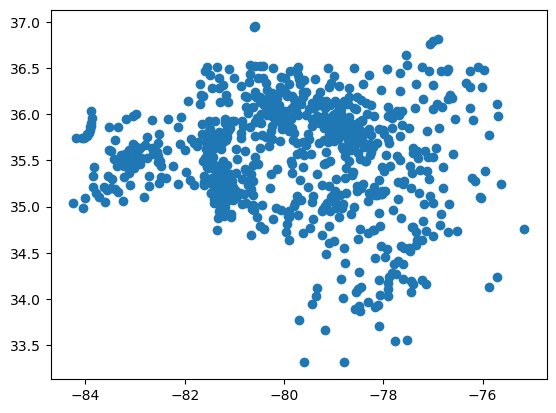

In [79]:
ips = lgcp_model.variational_strategy.inducing_points.detach().numpy()
ips = ips*std.numpy()  + mu.numpy()
plt.scatter(ips[:, 1], ips[:, 0])

Now, let's make our second GP

In [80]:
lgcp_model.eval()

with torch.no_grad():
    f_mean = lgcp_model(train_X).mean
latent = f_mean.numpy()

# Normalize latent before plugging into model!
from sklearn.preprocessing import StandardScaler
scaler_latent = StandardScaler()
latent_scaled = scaler_latent.fit_transform(latent.reshape(-1, 1)).flatten()



In [81]:
with torch.no_grad():
    function_dist = lgcp_model(train_X)
    samples = function_dist(torch.Size([1000]))

In [82]:
latent = samples.mean(dim=0)

### Introduce covariates to the model.

In [83]:
elevation = df_obs["elevation"].values.copy()
t_s = df_obs[t_s_col].values.copy()

scaler_elev = StandardScaler().fit(elevation.reshape(-1, 1))
scaler_ts = StandardScaler().fit(t_s.reshape(-1, 1))
elevation_scaled = scaler_elev.transform(elevation.reshape(-1, 1)).flatten()
t_s_scaled = scaler_ts.transform(t_s.reshape(-1, 1)).flatten()

x_2 = np.column_stack([X, elevation_scaled, t_s_scaled, latent_scaled])

In [84]:
from gpytorch.kernels import MaternKernel, LinearKernel, ScaleKernel

def make_kernel(which: str):
    """
    which ∈ {
      "matern_ll",
      "matern_ll_latent",
      "matern_ll_plus_linear_ll",
      "matern_ll_latent_plus_linear_ll"
    }
    _ll means lat/lon; _latent adds your LGCP latent feature (col 4)
    """
    # Matérn choices (nu=1.5 is common for spatial; try 0.5 or 2.5 if you like)
    matern_ll = MaternKernel(nu=1.5, ard_num_dims=2, active_dims=[0, 1])
    matern_ll_latent = MaternKernel(nu=1.5, ard_num_dims=3, active_dims=[0, 1, 4])

    # Dot-product (linear) over lat/lon only
    linear_ll = LinearKernel(active_dims=[0, 1])

    if which == "matern_ll":
        base = matern_ll
    elif which == "matern_ll_latent":
        base = matern_ll_latent
    elif which == "matern_ll_plus_linear_ll":
        base = matern_ll + linear_ll
    elif which == "matern_ll_latent_plus_linear_ll":
        base = matern_ll_latent + linear_ll
    else:
        raise ValueError(f"Unknown kernel spec: {which}")

    # Put a global output scale on the whole thing
    return ScaleKernel(base)


In [85]:
from gpytorch.means import LinearMean
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import RBFKernel, MaternKernel, LinearKernel
from gpytorch.means import LinearMean, ConstantMean

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, covar_module):
        super().__init__(train_x, train_y, likelihood)
        # keep your linear mean over (elev, t_s, latent) = cols [2,3,4]
        self.mean_module = LinearMean(input_size=3)
        self.covar_module = covar_module

        # does initializing weights help???
        with torch.no_grad():
            w = torch.tensor([0.0, 0.0, 0.5], dtype=train_y.dtype, device=train_y.device)
            b = train_y.mean()
            self.mean_module.initialize(weights=w, bias=b)


    def forward(self, x):
        mean_x = self.mean_module(x[:, 2:5])  # [elev, t_s, latent]
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


In [86]:
# train_X_gp = torch.tensor(x_2, dtype=torch.get_default_dtype())
# mean = train_X_gp.mean(axis=0)
# std = train_X_gp.std(axis=0)
# train_X_gp = (train_X_gp - mean) / std

# ---- build TRAIN design for 2nd GP (raw, then one scaler) ----
# X are raw lat/lon (not pre-standardized for the 2nd GP)
x_train_raw = np.column_stack([X, elevation_scaled, t_s_scaled, latent_scaled])  # shape (N,5)
train_X_gp = torch.tensor(x_train_raw, dtype=torch.get_default_dtype())

# fit a single scaler on the full 5-D design
gp_mean = train_X_gp.mean(0)
gp_std  = train_X_gp.std(0) + 1e-12
train_X_gp = (train_X_gp - gp_mean) / gp_std

# Build train_X_gp exactly as you already do (scaled x_2)
which_kernel = "matern_ll_latent_plus_linear_ll"  # try each of the four
covar_module = make_kernel(which_kernel)

likelihood = GaussianLikelihood()
model = GPModel(train_X_gp, train_y, likelihood, covar_module)



In [87]:
# Import marginal log likelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

# Train the GP
model.train()
likelihood.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for i in range(100):
    optimizer.zero_grad()
    output = model(train_X_gp)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iter {i + 1}/1000 - Loss: {loss.item()}")

Iter 1/1000 - Loss: 1.6272248029708862
Iter 11/1000 - Loss: 1.4853549003601074
Iter 21/1000 - Loss: 1.4670113325119019
Iter 31/1000 - Loss: 1.451891541481018
Iter 41/1000 - Loss: 1.443272590637207
Iter 51/1000 - Loss: 1.438232421875
Iter 61/1000 - Loss: 1.4402592182159424
Iter 71/1000 - Loss: 1.437654972076416
Iter 81/1000 - Loss: 1.4401530027389526
Iter 91/1000 - Loss: 1.4331727027893066


In [88]:
model.mean_module.weights

Parameter containing:
tensor([[-1.6903],
        [ 0.4352],
        [ 0.2487]], requires_grad=True)

In [89]:
model.mean_module.bias

Parameter containing:
tensor([27.0865], requires_grad=True)

In [90]:
# Get predicted log-intensity across the field grid
test_X_latlon = torch.tensor(areal_units_all[["centroid_lat","centroid_lon"]].to_numpy(), dtype=torch.get_default_dtype())
with torch.no_grad():
    pred_field = lgcp_model(test_X).mean  # test_X already includes all Durham centroids

In [91]:
# Define df_full_all (we'd like to predict on ALL areal units, even waterID units)
df_elev_use = df_elev[["GEOID", "elevation"]].drop_duplicates("GEOID")
modis_use = modis_df[["GEOID", t_s_col]].drop_duplicates("GEOID")

df_full_all = (
    areal_units_all[["GEOID", "centroid_lat", "centroid_lon"]]
    .merge(df_elev_use, on="GEOID", how="left")
    .merge(modis_use, on="GEOID", how="left")
)
df_full_all = df_full_all.rename(columns={
    "centroid_lat": "lat",
    "centroid_lon": "lon",
})

# Use the same imputer you fit on training
df_full_all[["lat", "lon", "elevation", t_s_col]] = imputer.transform(
    df_full_all[["lat", "lon", "elevation", t_s_col]]
)

In [92]:
# Scale covariates with train-fitted scalers
elevation_test = scaler_elev.transform(
    df_full_all["elevation"].to_numpy().reshape(-1, 1)).ravel()
t_s_test = scaler_ts.transform(
    df_full_all[t_s_col].to_numpy().reshape(-1, 1)).ravel()
latent_test = scaler_latent.transform(pred_field.reshape(-1, 1))#.ravel()
# latlon_np = df_full_all[["lat", "lon"]].to_numpy()
# latlon = torch.tensor(latlon_np, dtype=torch.get_default_dtype())

# # Combine into test_X
# test_X_np = np.column_stack([test_X, elevation_test, t_s_test, latent_test])
# test_X = torch.tensor(test_X_np, dtype=torch.float32)

# build test design for 2nd GP the same way
# IMPORTANT: use original lat/lon centroids here (not LGCP-standardized ones)
latlon_np = df_full_all[["lat","lon"]].to_numpy()
test_raw = np.column_stack([latlon_np, elevation_test, t_s_test, latent_test])
test_X_gp = torch.tensor(test_raw, dtype=torch.get_default_dtype())
test_X_gp = (test_X_gp - gp_mean) / gp_std

# Perform inference on these values
model.eval()
likelihood.eval()
with torch.no_grad():
    observed_pred = likelihood(model(test_X_gp))
    mean_ps = observed_pred.mean
    lower, upper = observed_pred.confidence_region()

In [93]:
test_X_gp.mean(axis=0)

tensor([ 0.0163,  0.1169, -0.2093,  0.2202,  0.6467])

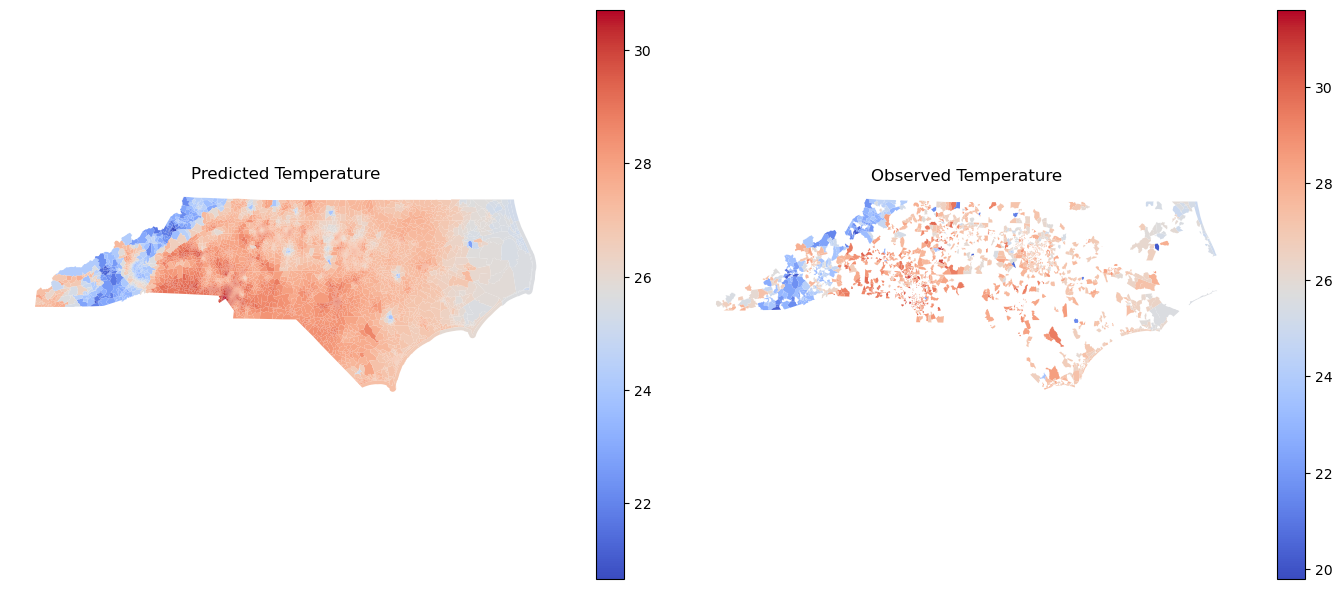

In [94]:
# Attach predictions and actuals back to tracts GeoDataFrame
areal_units_pred = areal_units_all.copy()
areal_units_pred["GEOID"] = areal_units_pred["GEOID"].astype(str)
assert len(mean_ps) == len(areal_units_pred)
areal_units_pred["predicted_temp"] = mean_ps.numpy()
obs_temp = df_obs[["GEOID", f"{time_slot}_temp"]].drop_duplicates("GEOID").rename(columns={f"{time_slot}_temp": "true_temp"})
areal_units_pred = areal_units_pred.merge(obs_temp, on="GEOID", how="left")

# Plot predicted vs. actual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
areal_units_pred.plot(column="predicted_temp", cmap="coolwarm", legend=True, ax=ax1)
ax1.set_title("Predicted Temperature")
ax1.axis("off")
areal_units_pred.plot(column="true_temp", cmap="coolwarm", legend=True, ax=ax2)
ax2.set_title("Observed Temperature")
ax2.axis("off")

plt.tight_layout()


In [95]:
areal_units_pred = areal_units_pred.rename(columns={"predicted_temp": "lgcp_gp"})  # name match convention

<Axes: >

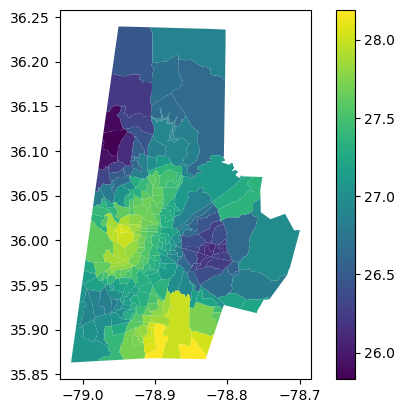

In [96]:
areal_units_pred[keep].plot('lgcp_gp', legend=True)

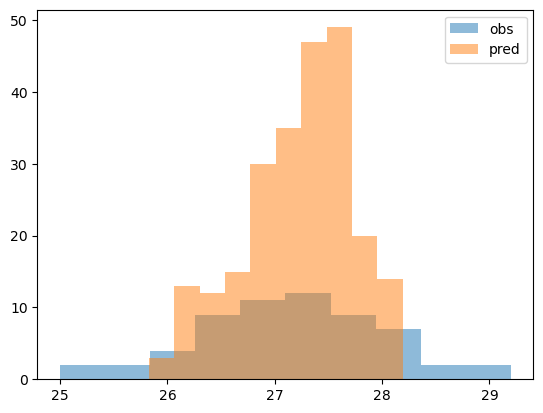

In [97]:
plt.hist(areal_units_pred[keep][f'{time_slot}_temp'], label='obs', alpha=0.5)
plt.hist(areal_units_pred[keep]['lgcp_gp'], label='pred', alpha=0.5)
plt.legend()

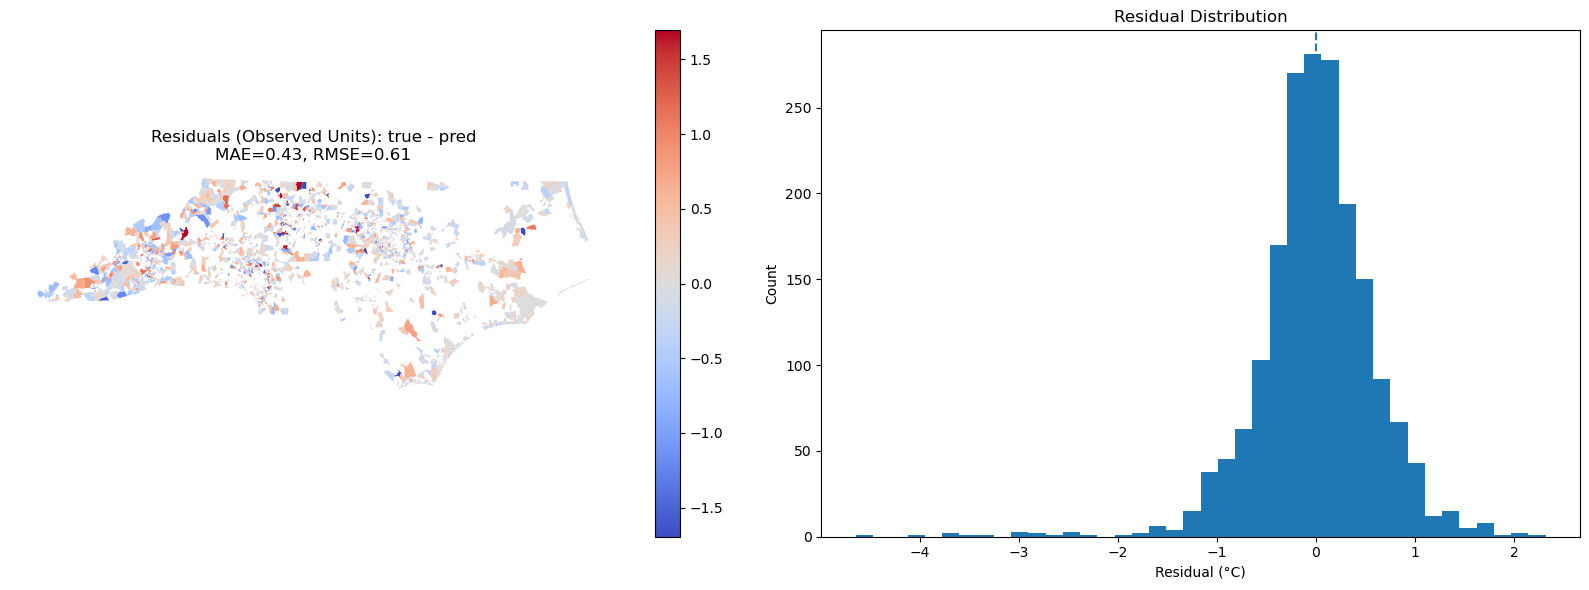

In [98]:
# 1) Compute residuals on observed units only
gdf = areal_units_pred.copy()
gdf["resid"] = gdf["true_temp"] - gdf["lgcp_gp"]  # (+) = model too cold; (-) = model too warm
gdf_obs = gdf.loc[gdf["true_temp"].notna()].copy()

# 2) Symmetric, outlier-robust color limits around 0 (use 1st/99th percentiles)
if len(gdf_obs):
    lo, hi = np.nanpercentile(gdf_obs["resid"], [1, 99])
    lim = float(np.nanmax(np.abs([lo, hi])))
    vmin, vmax = -lim, lim
else:
    vmin, vmax = -1.0, 1.0  # fallback

# 3) Quick metrics
mae = float(np.nanmean(np.abs(gdf_obs["resid"])))
rmse = float(np.sqrt(np.nanmean(np.square(gdf_obs["resid"]))))

# 4) Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Residual choropleth
gdf_obs.plot(
    column="resid",
    cmap="coolwarm",
    vmin=vmin,
    vmax=vmax,
    legend=True,
    ax=axes[0],
    linewidth=0,  # cleaner fill
)
axes[0].set_title(f"Residuals (Observed Units): true - pred\nMAE={mae:.2f}, RMSE={rmse:.2f}")
axes[0].axis("off")

# Residual histogram
axes[1].hist(gdf_obs["resid"].dropna(), bins=40)
axes[1].axvline(0.0, linestyle="--")
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (°C)")
axes[1].set_ylabel("Count")

plt.tight_layout()

# (Optional) Save a shapefile/GeoJSON with residuals for GIS inspection
# gdf_obs[["GEOID", "resid", "geometry"]].to_file("nc_residuals_obs.shp")
# gdf_obs[["GEOID", "resid", "geometry"]].to_file("nc_residuals_obs.geojson", driver="GeoJSON")


<Axes: >

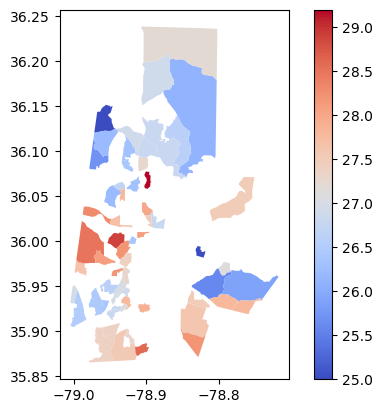

In [99]:
areal_units_pred[keep].plot(f'{time_slot}_temp', cmap='coolwarm', legend=True)

In [100]:
# should be near zero/one
print("train scaler means:", gp_mean.tolist())
print("train scaler stds :", gp_std.tolist())

# ensure the *same* gp_mean/gp_std are used on test
print("test_X_gp (first row) after scaling:", test_X_gp[0])

# latent consistency
print("latent_train mean/std:", float(latent_scaled.mean()), float(latent_scaled.std()))
print("latent_test  mean/std:", float(latent_test.mean()),  float(latent_test.std()))


train scaler means: [35.526824951171875, -79.83451843261719, 1.013468975408216e-09, 3.0404070372469505e-09, 1.722897202682816e-08]
train scaler stds : [0.5748071074485779, 1.8062348365783691, 1.0002658367156982, 1.0002658367156982, 1.0002657175064087]
test_X_gp (first row) after scaling: tensor([ 1.6950,  0.0277, -0.2491, -0.2052,  0.1128])
latent_train mean/std: 1.6215503606531456e-08 1.0
latent_test  mean/std: 0.6468961805902447 1.034777366215444


In [101]:
# Save shp file of predictions:
areal_units_pred = areal_units_pred.rename(columns={"predicted_temp": "lgcp_gp"})  # name match convention
preds_shp_file = f"ps_on_nc/nc/lgcp_gp_tract_{wu_date}_{time_slot}.shp" if census_group_type == 'tract' else f"ps_on_nc/nc/lgcp_gp_bg_{wu_date}_{time_slot}.shp"
areal_units_pred.to_file(preds_shp_file)

# Save just city results to shp file:
if census_group_type == 'block_group': 
    census_group_abbrv = 'bg'
else: 
    census_group_abbrv = 'tract'

city = areal_units_pred[keep]
city_lgcp_shp_path = f"ps_on_nc/{city_name}/{city_name}_lgcp_gp_{census_group_abbrv}_{m}_{wu_date}_{time_slot}.shp"
city.to_file(city_lgcp_shp_path)
print(city_lgcp_shp_path)

/var/folders/wh/fhcq_pkj52nc_krcfphv4rxh0000gn/T/ipykernel_1967/659186594.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  areal_units_pred.to_file(preds_shp_file)
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'centroid_lon' to 'centroid_l'
  ogr_write(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'centroid_lat' to 'centroid_1'
  ogr_write(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'log_lambda_mean' to 'log_lambda'
  ogr_write(


ps_on_nc/durham/durham_lgcp_gp_bg_800_jul23_2021_eve.shp


/var/folders/wh/fhcq_pkj52nc_krcfphv4rxh0000gn/T/ipykernel_1967/659186594.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  city.to_file(city_lgcp_shp_path)
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'centroid_lon' to 'centroid_l'
  ogr_write(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'centroid_lat' to 'centroid_1'
  ogr_write(
/opt/homebrew/Caskroom/miniforge/base/envs/torch-env/lib/python3.13/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'log_lambda_mean' to 'log_lambda'
  ogr_write(


## NOAA validation

In [108]:
if city_name == "chapel_hill":
    raise SystemExit # Stop the cell here (don't do NOAA Validation)

noaa_time_slot = "pm" if time_slot == 'eve' else "am"
noaa_trav_locs = "raleigh_durham" if city_name in ["durham", "raleigh"] else city_name

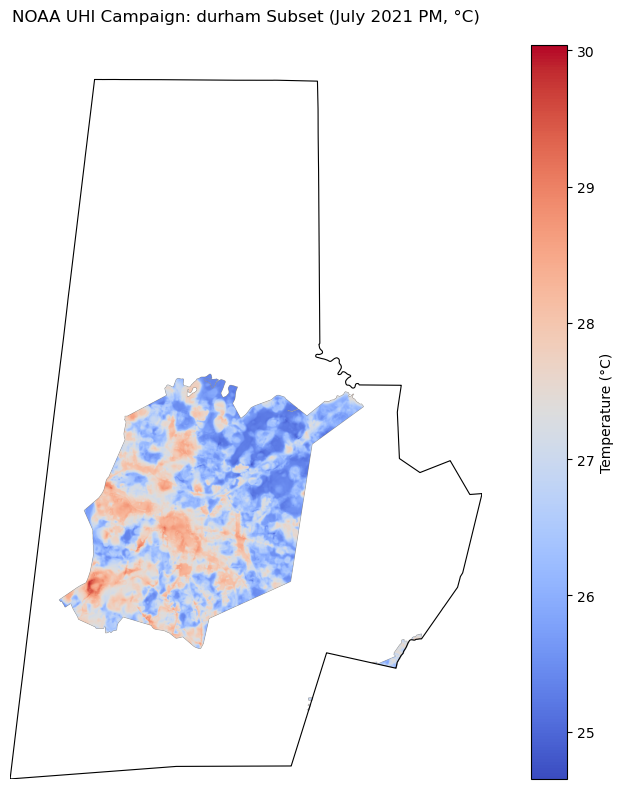

In [109]:
from shapely.geometry import mapping
from rasterio.mask import mask

city_units_with_preds = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_svgpr_ps_{census_group_abbrv}_800_{wu_date}_{time_slot}.shp")

# 2. Match CRS between shapefile and raster
with rasterio.open(f"data/noaa_{city_name}/{noaa_trav_locs}_noaa_{noaa_time_slot}.tif") as src:
    raster_crs = src.crs
    city_units_proj = city_units_with_preds.to_crs(raster_crs)

    # 3. Clip raster to Durham geometries
    shapes = [mapping(geom) for geom in city_units_proj.geometry]
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta.copy()

# 4. Clean and convert Fahrenheit → Celsius
out_image = out_image.astype(np.float32)
out_image_clean = np.where((out_image > -40) & (out_image < 150), out_image, np.nan)
out_image_celsius = (out_image_clean - 32) * 5.0 / 9.0

from rasterio.plot import plotting_extent

# extent from the *cropped* transform
extent = plotting_extent(out_image_celsius[0], out_transform)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    out_image_celsius[0],
    extent=extent,     # <-- place pixels correctly
    origin="upper",    # north-up (raster origin is top-left)
    cmap="coolwarm",
)
plt.colorbar(im, ax=ax, label="Temperature (°C)")

# Optional: dissolve to a single Durham outline for a clean border
city_outline = city_units_proj.dissolve()  # merges all block groups
city_outline.boundary.plot(ax=ax, color="black", linewidth=0.8)

plt.title(f"NOAA UHI Campaign: {city_name} Subset (July 2021 PM, °C)")
plt.axis("off")
plt.tight_layout()
plt.show()


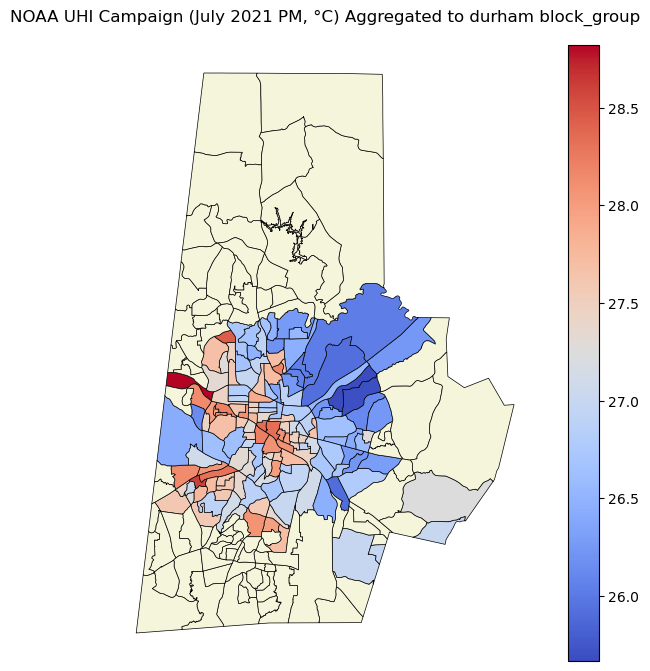

In [110]:
# 3) Zonal stats using the CROPPED transform
from rasterstats import zonal_stats

stats = zonal_stats(
    vectors=city_units_proj,            # GeoDataFrame is fine
    raster=out_image_celsius[0],                    # numpy array
    affine=out_transform,               # <-- critical
    stats=["mean"],
    nodata=np.nan,
    all_touched=False                   # set True if you want partial-pixel inclusion
)

city_units_proj["noaa_temp"] = [s["mean"] for s in stats]

# 4) Plot, showing polygons with no data as gray
ax = city_units_proj.plot(
    column="noaa_temp", cmap="coolwarm", legend=True, figsize=(9,8),
    edgecolor="black", linewidth=0.5,
    missing_kwds={"color": "beige", "label": "no NOAA coverage"}
)
plt.title(f"NOAA UHI Campaign (July 2021 PM, °C) Aggregated to {city_name} {census_group_type}")
plt.axis("off")
plt.show()

In [111]:
from spatial_uncertainty import corr_with_spatial_uncertainty


# Compute NOAA tract data to ExactGP predictions and LGCP+GP predictions:

lgcp_gp_gdf = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_lgcp_gp_{census_group_abbrv}_{m}_{wu_date}_{time_slot}.shp")
lgcp_gp_gdf["GEOID"] = lgcp_gp_gdf["GEOID"].astype(str)
svgpr_gdf = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_svgpr_{census_group_abbrv}_800_{wu_date}_{time_slot}.shp")
svgpr_gdf["GEOID"] = svgpr_gdf["GEOID"].astype(str)
svgpr_gdf = svgpr_gdf.rename(columns={"pred_temp": "svgpr"})
svgpr_ps_gdf = gpd.read_file(f"ps_on_nc/{city_name}/{city_name}_svgpr_ps_{census_group_abbrv}_800_{wu_date}_{time_slot}.shp")
svgpr_ps_gdf["GEOID"] = svgpr_ps_gdf["GEOID"].astype(str)
city_units_proj["GEOID"] = city_units_proj["GEOID"].astype(str)

df_compare = pd.merge(
    city_units_proj[["GEOID", "noaa_temp", "svgpr_ps"]],
    lgcp_gp_gdf[["GEOID", "lgcp_gp"]],
    on="GEOID",
    how="inner"
)

df_compare = pd.merge(
    df_compare,
    svgpr_gdf[["GEOID", "svgpr"]],
    on="GEOID",
    how="inner"
)

# Now drop any rows that are missing any of the columns involved in correlation
df_compare = df_compare.dropna(subset=["lgcp_gp", "noaa_temp", "svgpr_ps", "svgpr"])

################ NEW CHANGES BELOW: WANT TO COMPUTE UNCERTAINTY AS WELL ###########################

# 1) Project polygons to metric CRS
city_metric = city_units_proj.to_crs("EPSG:3857")

# 2) Merge geometry + NOAA + predictions into ONE aligned dataframe
df_geo = city_metric.merge(df_compare, on="GEOID", how="inner")

# 3) Make sure df_geo is a proper GeoDataFrame
df_geo = gpd.GeoDataFrame(df_geo, geometry="geometry", crs=city_metric.crs)

print("len(df_geo) =", len(df_geo))

# 4) Use centroids (points) in metric CRS, then take x/y
centroids = df_geo.geometry.centroid
coords_m = np.column_stack(
    [centroids.x.to_numpy(),
     centroids.y.to_numpy()]
)

# Extra assertion to catch any weirdness early:
assert len(coords_m) == len(df_geo), "coords_m and df_geo length mismatch!"

print(f"{census_group_type} data ({city_name}) - {time_slot}:")

r_svgpr, sd_svgpr, lo_svgpr, hi_svgpr, Meff_svgpr = corr_with_spatial_uncertainty(
    df_compare["svgpr"], df_compare["noaa_temp"], coords_m,
    label="SVGPR vs NOAA TIF"
)

r_svgpr_ps, sd_svgpr_ps, lo_svgpr_ps, hi_svgpr_ps, Meff_svgpr_ps = corr_with_spatial_uncertainty(
    df_compare["svgpr_ps"], df_compare["noaa_temp"], coords_m,
    label="SVGPR+PS vs NOAA TIF"
)

r_lgcp_gp, sd_lgcp_gp, lo_lgcp_gp, hi_lgcp_gp, Meff_lgcp_gp = corr_with_spatial_uncertainty(
    df_compare["lgcp_gp"], df_compare["noaa_temp"], coords_m,
    label="LGCP+GP vs NOAA TIF"
)

print(f"SVGPR+PS - SVGPR: Δr = {r_svgpr_ps - r_svgpr:.2f}")
print(f"LGCP+GP - SVGPR: Δr = {r_lgcp_gp - r_svgpr:.2f}")


# print(f"{census_group_type} data ({city_name}) - {time_slot}:")
# r_svgpr, p_svgpr = pearsonr(df_compare["svgpr"], df_compare["noaa_temp"])
# print(f"SVGPR vs NOAA TIF: r = {r_svgpr:.2f}, p = {p_svgpr:.2e}")
# r_svgpr_ps, p_svgpr_ps = pearsonr(df_compare["svgpr_ps"], df_compare["noaa_temp"])
# print(f"SVGPR+PS vs NOAA TIF: r = {r_svgpr_ps:.2f}, p = {p_svgpr_ps:.2e}")
# r_lgcp_gp, p_lgcp_gp = pearsonr(df_compare["lgcp_gp"], df_compare["noaa_temp"])
# print(f"LGCP+GP vs NOAA TIF: r = {r_lgcp_gp:.2f}, p = {p_lgcp_gp:.2e}")
# print(f"SVGPR+PS - SVGPR: r_2 - r_1 = {r_svgpr_ps - r_svgpr:.2f}")
# print(f"LGCP+GP - SVGPR: r_3 - r_1 = {r_lgcp_gp - r_svgpr:.2f}")

len(df_geo) = 147
block_group data (durham) - eve:
SVGPR vs NOAA TIF: r = 0.34 ± 0.09 (95% CI [0.16, 0.50]), p = 2.53e-05, M_eff = 101.8
SVGPR+PS vs NOAA TIF: r = 0.40 ± 0.09 (95% CI [0.20, 0.56]), p = 5.67e-07, M_eff = 85.5
LGCP+GP vs NOAA TIF: r = 0.44 ± 0.09 (95% CI [0.24, 0.61]), p = 1.85e-08, M_eff = 73.8
SVGPR+PS - SVGPR: Δr = 0.06
LGCP+GP - SVGPR: Δr = 0.10


Shared color scale: 25.83-28.20 °C


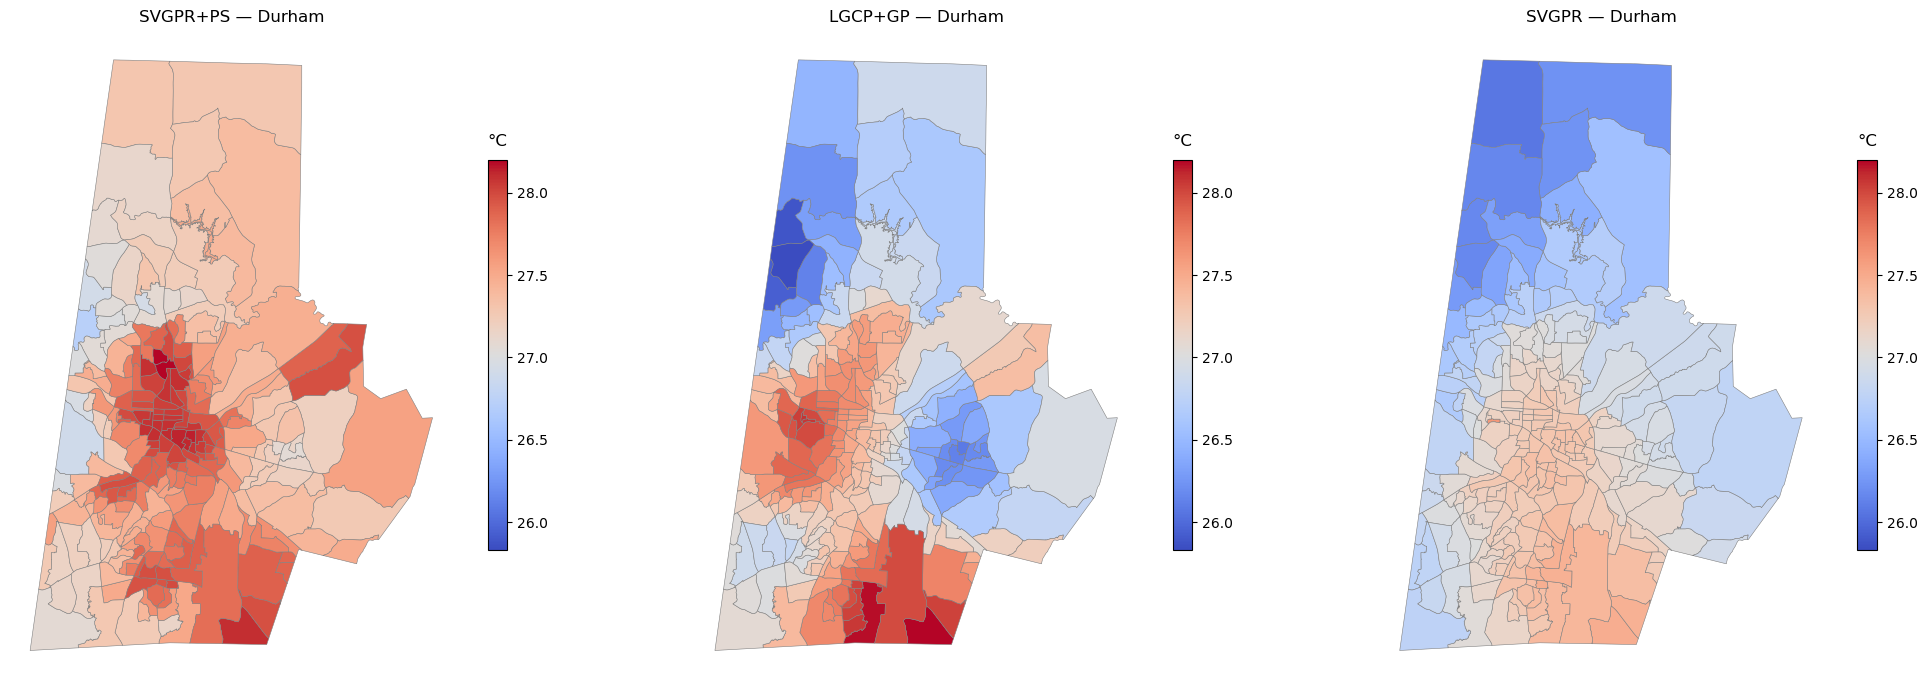

In [112]:
# Compute shared vmin/vmax for consistent color scale
vmin = min(
    svgpr_ps_gdf["svgpr_ps"].min(),
    lgcp_gp_gdf["lgcp_gp"].min(),
    svgpr_gdf["svgpr"].min() )
vmax = max(
    svgpr_ps_gdf["svgpr_ps"].max(),
    lgcp_gp_gdf["lgcp_gp"].max(),
    svgpr_gdf["svgpr"].max() )

print(f"Shared color scale: {vmin:.2f}-{vmax:.2f} °C")

# Setup figure with 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(21, 7))

# SVGPR+PS
svgpr_ps_gdf.plot(
    column="svgpr_ps",
    cmap="coolwarm",
    edgecolor="gray",
    linewidth=0.4,
    legend=True,
    ax=axs[0],
    vmin=vmin, vmax=vmax,
    legend_kwds={"shrink": 0.6}
)
axs[0].set_title(f"SVGPR+PS — {city_name.capitalize()}")
axs[0].set_axis_off()

# LGCP+GP
lgcp_gp_gdf.plot(
    column="lgcp_gp",
    cmap="coolwarm",
    edgecolor="gray",
    linewidth=0.4,
    legend=True,
    ax=axs[1],
    vmin=vmin, vmax=vmax,
    legend_kwds={"shrink": 0.6}
)
axs[1].set_title(f"LGCP+GP — {city_name.capitalize()}")
axs[1].set_axis_off()

# SVGPR
svgpr_gdf.plot(
    column="svgpr",
    cmap="coolwarm",
    edgecolor="gray",
    linewidth=0.4,
    legend=True,
    ax=axs[2],
    vmin=vmin, vmax=vmax,
    legend_kwds={"shrink": 0.6}
)
axs[2].set_title(f"SVGPR — {city_name.capitalize()}")
axs[2].set_axis_off()

for cb_ax in fig.axes[3:]:
    cb_ax.set_title("°C", fontsize=12, pad=10)

plt.tight_layout()
plt.show()
